## **1. PRELIMINARY DATA ANALYSIS AND CLEANING**

In [54]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Note: The video uses MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import zipfile

# Import all the models to test
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import requests
from sklearn.ensemble import RandomForestClassifier # This is the model that is actually tuned


##### 1. Download, unzip and load folder

In [4]:
zip_file = r"https://archive.ics.uci.edu/static/public/186/wine+quality.zip"
filename = "wine_file.zip"
try:
    response = requests.get(zip_file, stream=True)
    response.raise_for_status()
    with open(filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"File '{filename}' downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")






File 'wine_file.zip' downloaded successfully.


In [5]:
# open the zip file and load the dataset
with zipfile.ZipFile(filename) as z:
    with z.open("winequality-white.csv") as f:
       white_wine = pd.read_csv(f,sep=";")


In [6]:
# 2. Display the first 6 rows and dataset shape


white_wine.head(6)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [7]:
white_wine.shape

(4898, 12)

In [8]:
#3. check for missing values and handle them appropriately

def checking_for_missing_values(white_wine):
    print(" Missing Values:")
    missing_values =white_wine.isnull().sum()
    if missing_values.sum() > 0:
        print(missing_values[missing_values > 0])
    else:
        print("No missing values found in the dataset")
    return ()


In [9]:
checking_for_missing_values(white_wine)

 Missing Values:
No missing values found in the dataset


()

**There are no missing values present in our data**

#### 4. Check for duplicates and remove them if necessary.

In [10]:
def Check_for_duplicates(white_wine):
    print("\n2. Duplicate Rows:")
    duplicates = white_wine.duplicated().sum()
    white_wine.drop_duplicates()
    if duplicates > 0:
        print(f"Number of duplicate rows: {duplicates}")
    else:
        
        print(f"Percentage of duplicates: {(duplicates/len(white_wine))*100:.2f}%")


In [11]:
Check_for_duplicates(white_wine)


2. Duplicate Rows:
Number of duplicate rows: 937


In [12]:
# Remove the duplicates
white_wine.drop_duplicates()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


#### 5. Verify data types and correct them if needed

In [13]:
#verify data types and correct them if needed.
white_wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

#### 6. Provide a brief markdown summary of alla data cleaning and actions taken.

* The dataset provided which is the white wine quality dataset has a shape of 4898 rows and 12 columns.
* The data contained no missing values.
* The data contained 937 duplicates but was handled by removing it from the dataset.
* The data contained mostly float and just one integer data type. 

## **2.EXPLORATORY DATA ANALYSIS (EDA) AND SCALING**

#### 1. Perform univariate analysis on all numerical features (use any of histograms, boxplots, or countplots).


In [14]:
# Performing univariate analysis on all numerical columns
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: white_wine
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=white_wine, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=white_wine, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=white_wine, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        white_wine[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        white_wine[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

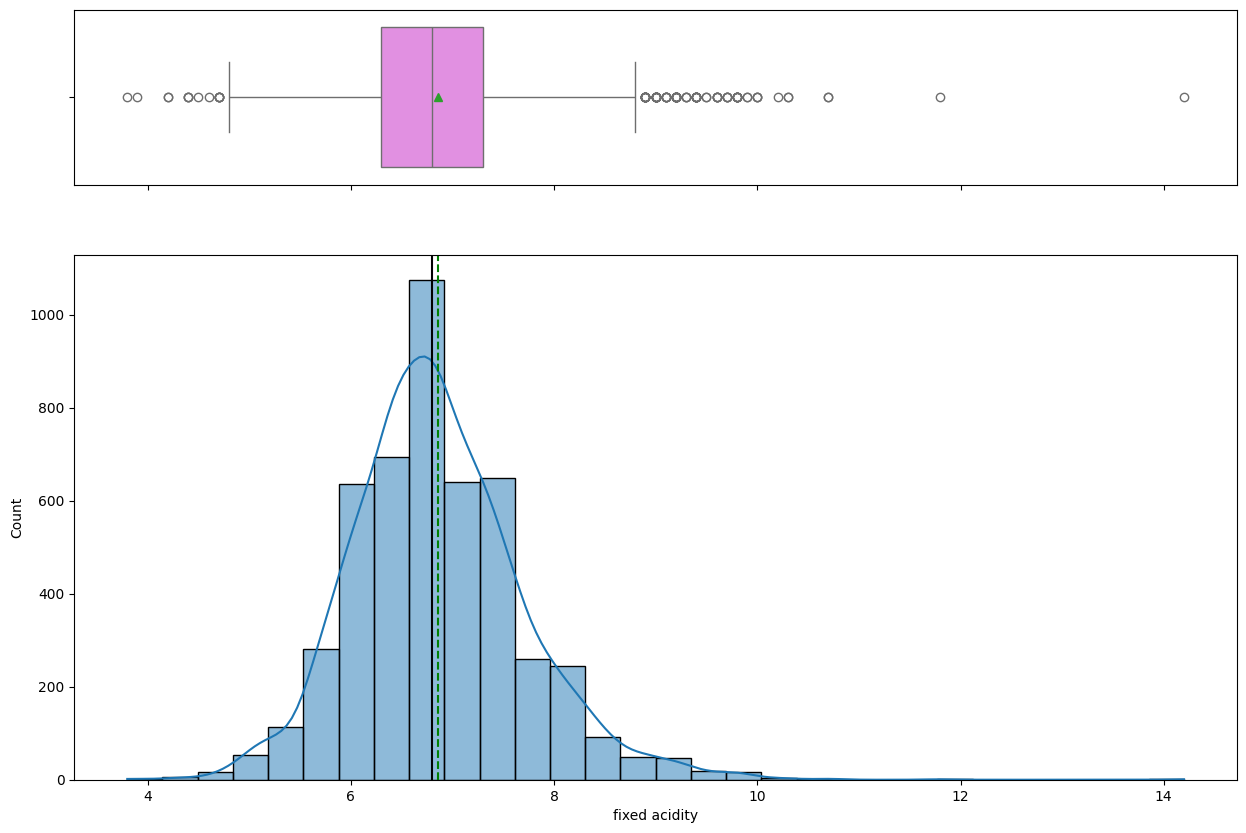

In [15]:
histogram_boxplot(white_wine, 'fixed acidity', kde=True, bins=30)

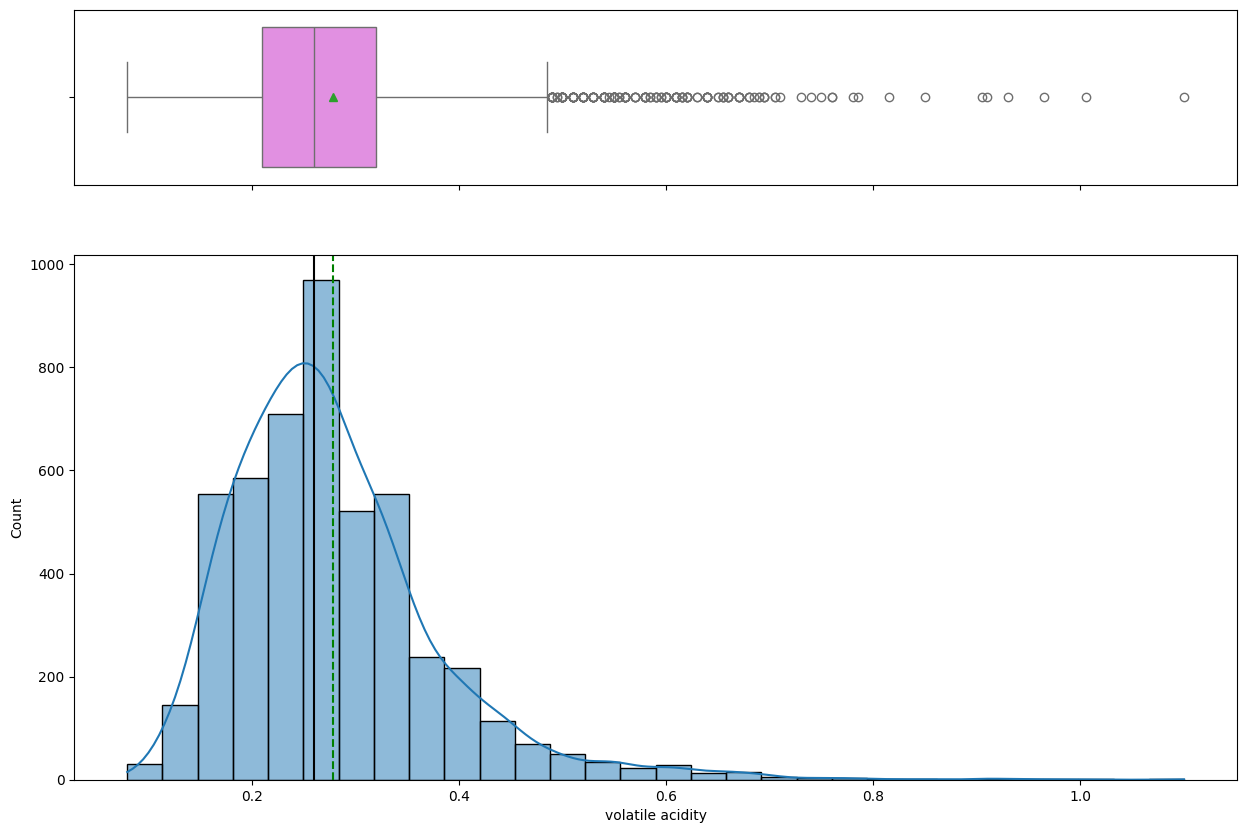

In [16]:
histogram_boxplot(white_wine, 'volatile acidity', kde=True, bins=30)

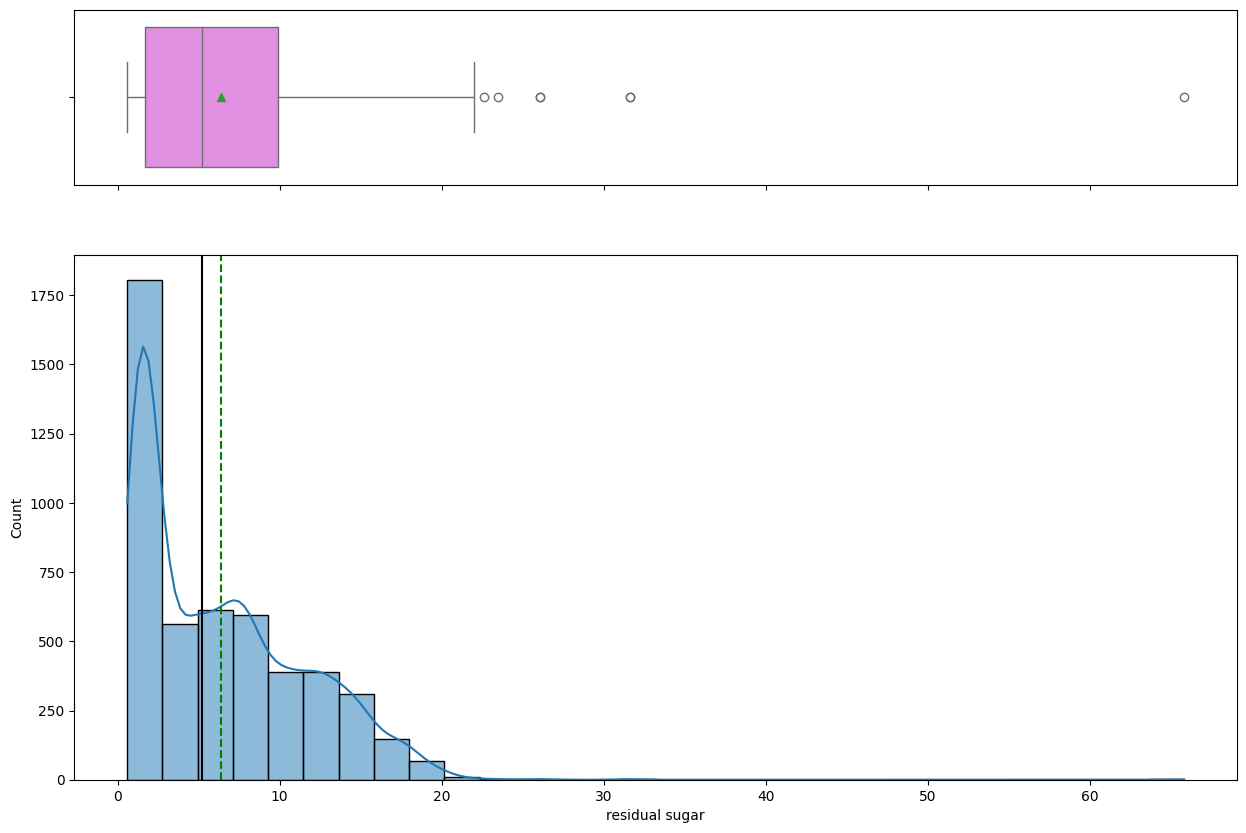

In [17]:
histogram_boxplot(white_wine, 'residual sugar', kde=True, bins=30)

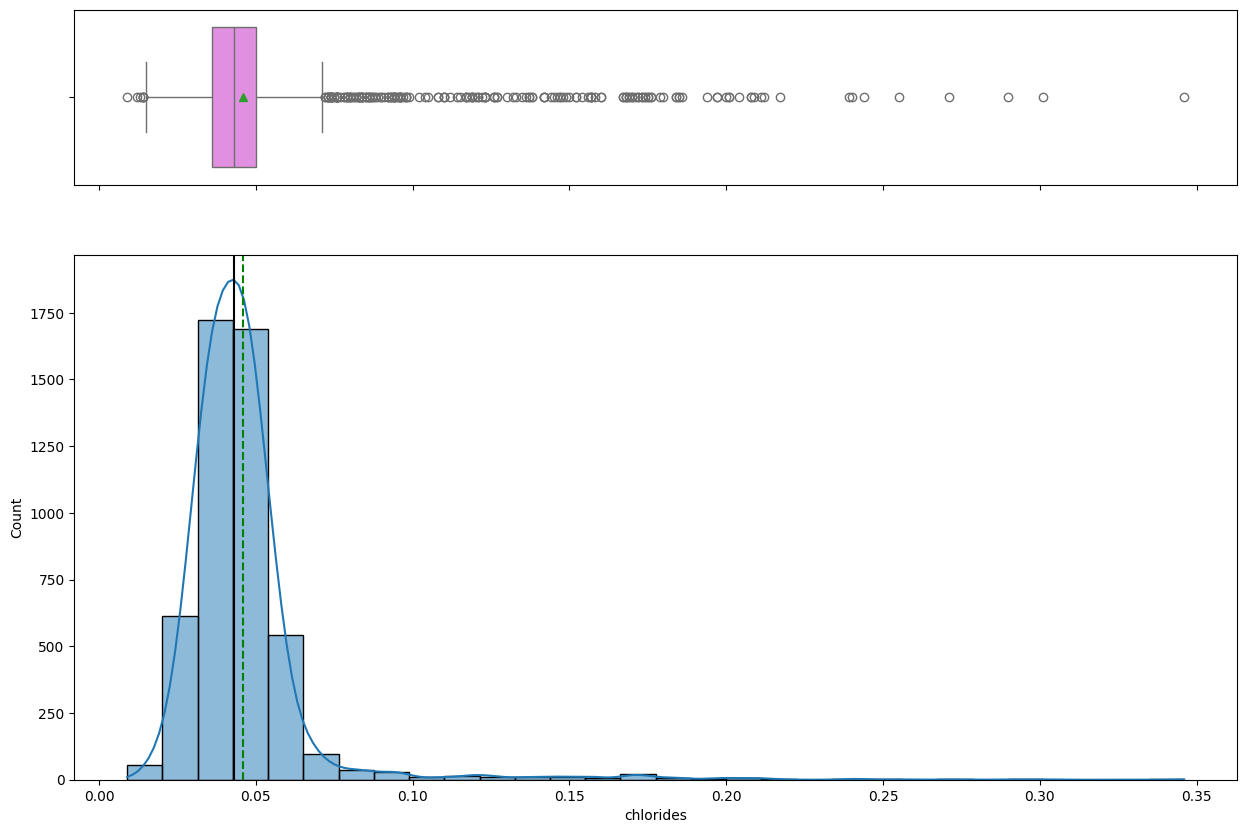

In [18]:
histogram_boxplot(white_wine, 'chlorides', kde=True, bins=30)

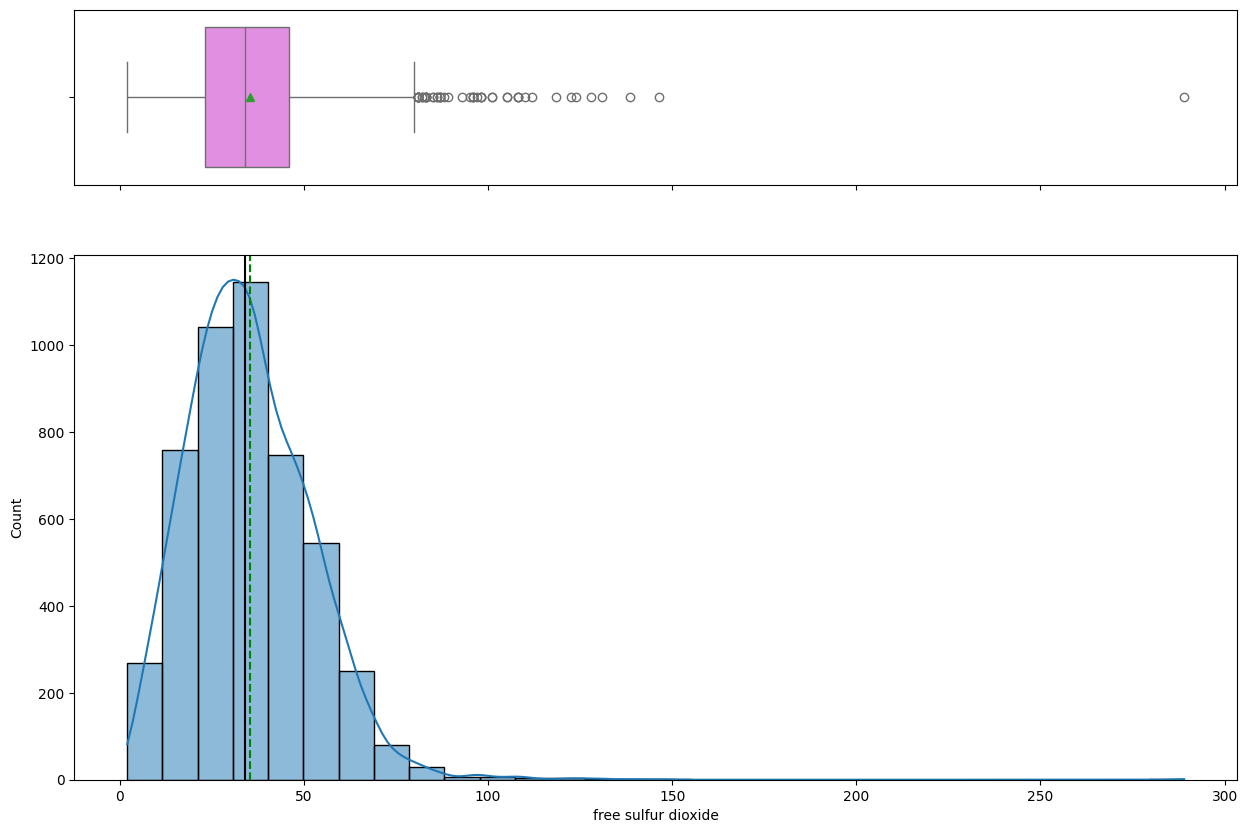

In [19]:
histogram_boxplot(white_wine, 'free sulfur dioxide', kde=True, bins=30)

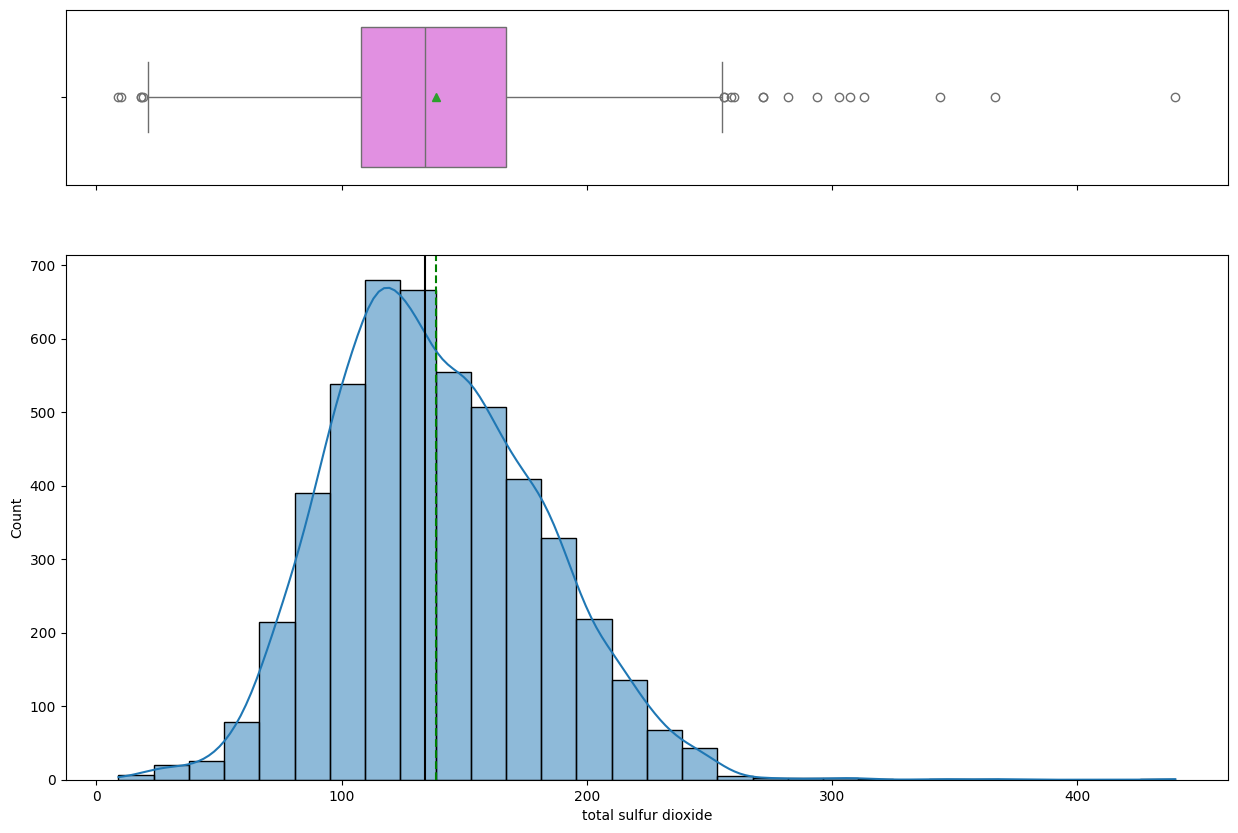

In [20]:
histogram_boxplot(white_wine, 'total sulfur dioxide', kde=True, bins=30)

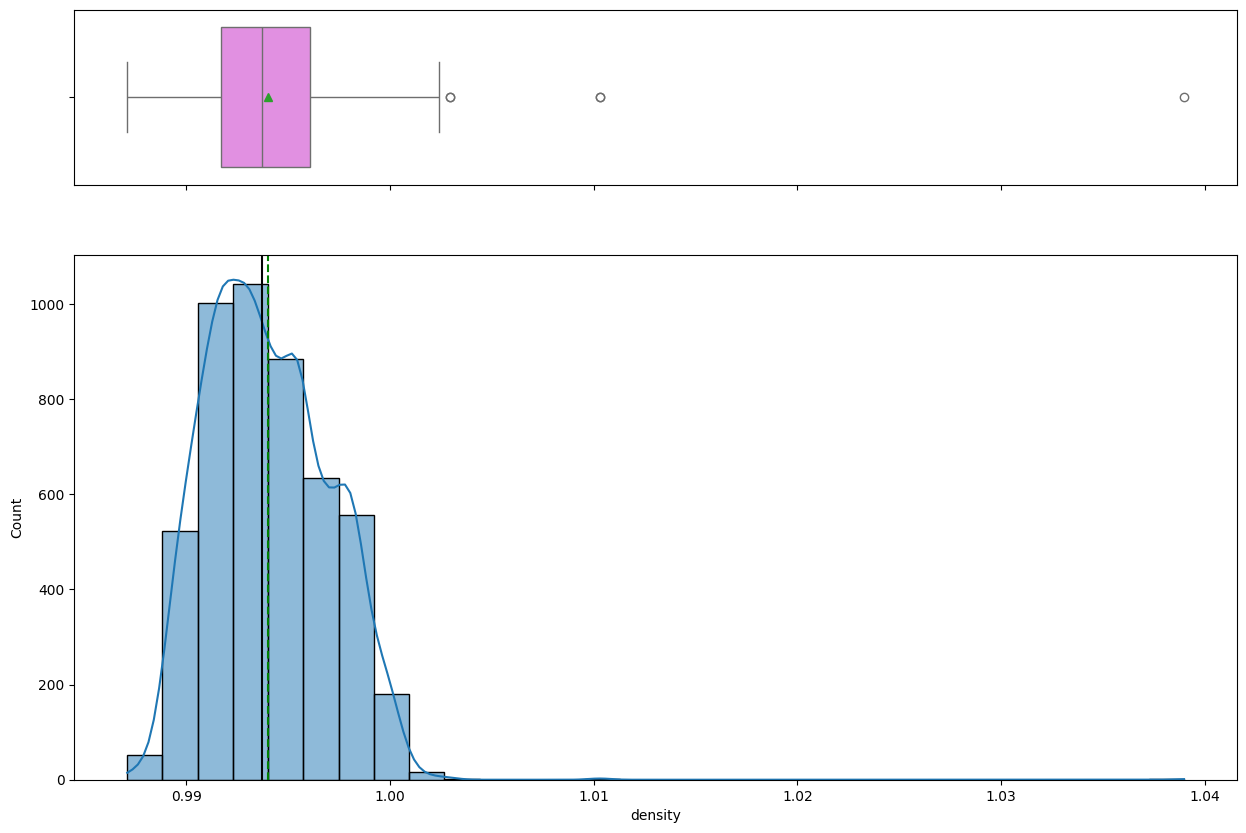

In [21]:
histogram_boxplot(white_wine, 'density', kde=True, bins=30)

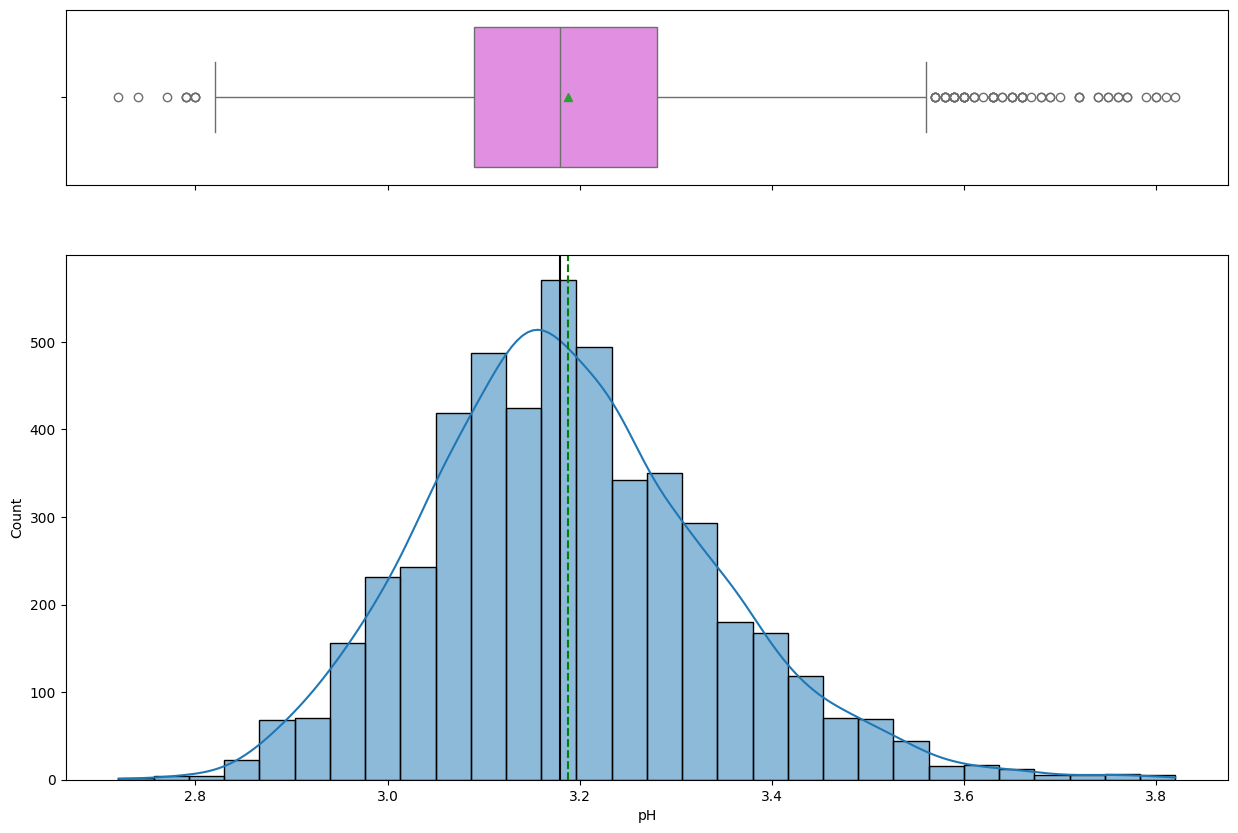

In [22]:
histogram_boxplot(white_wine, 'pH', kde=True, bins=30)

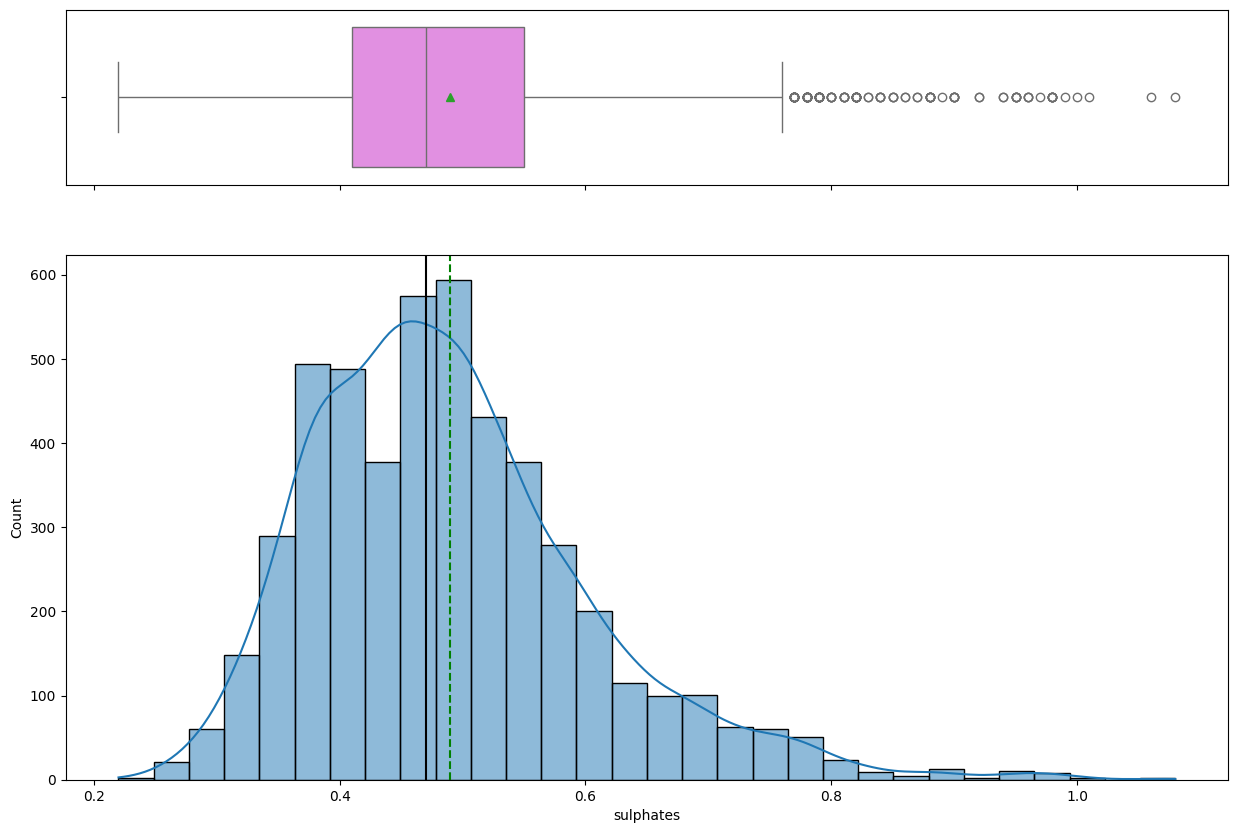

In [23]:
histogram_boxplot(white_wine, 'sulphates', kde=True, bins=30)

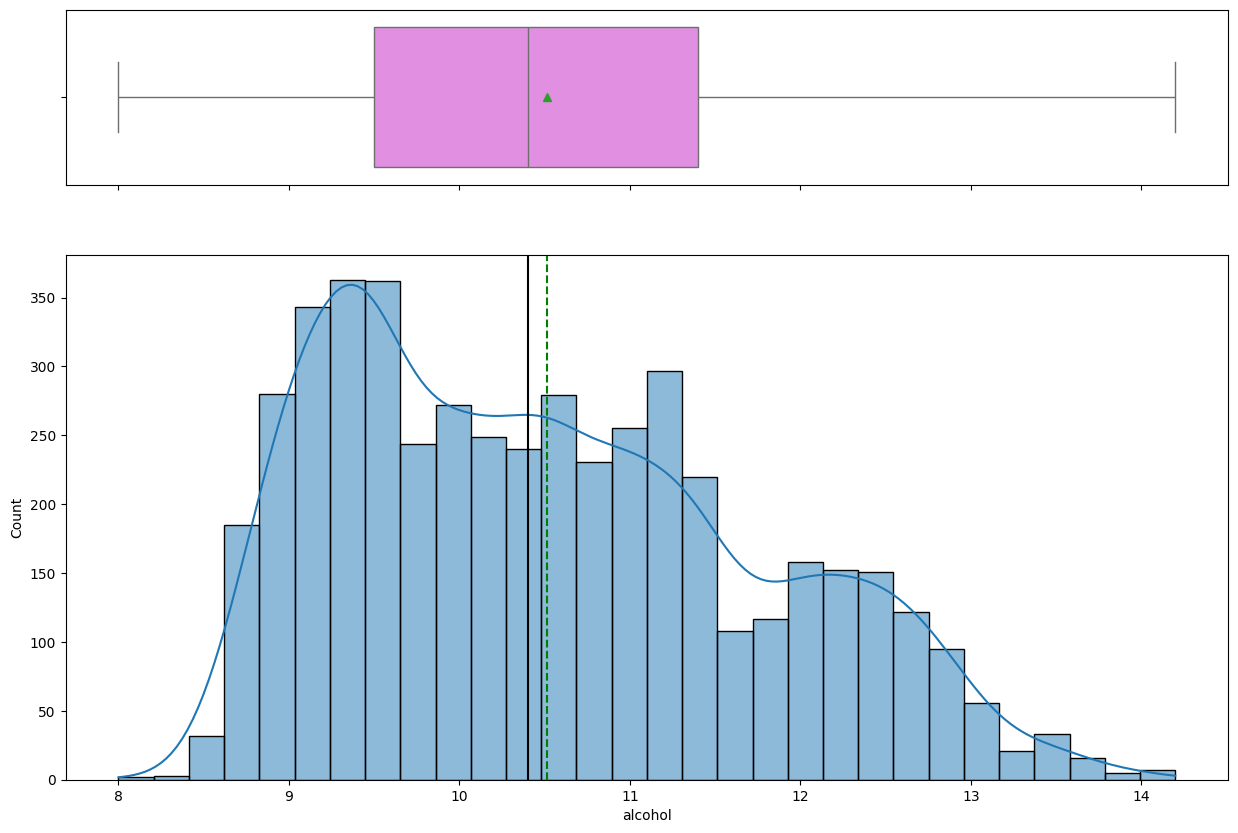

In [24]:
histogram_boxplot(white_wine, 'alcohol', kde=True, bins=30)

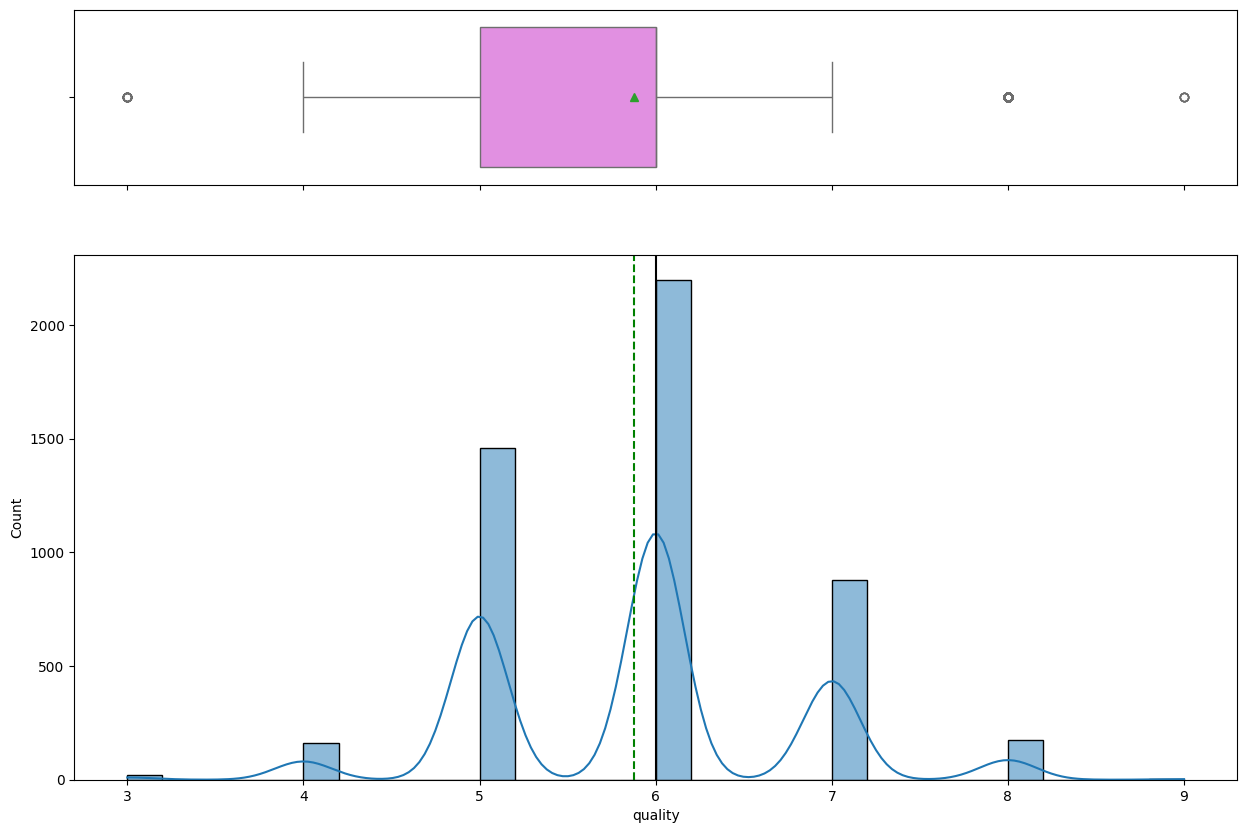

In [25]:
histogram_boxplot(white_wine, 'quality', kde=True, bins=30)

#### 2. Examine the correlation of each feature with target variable(quality)

In [26]:
# Correlation with target
def correlation_with_target(df, target_col, figsize=(10,2)):
  """
  Plots a heatmap showing correlation of each numeric feature against target_col.
  Returns a Series of correlations (sorted by absolute magnitude).
  """
  # compute correlations of every numeric column with the target
  corrs = df.corrwith(df[target_col]).drop(target_col)
  corrs_df = corrs.to_frame(name='corr').T  # shape (1, n)
  plt.figure(figsize=figsize)
  sns.heatmap(
      corrs_df,
      annot=True,
      fmt=".3f",
      cmap="coolwarm",
      center=0,
      vmin=-1,
      vmax=1,
      cbar_kws={'orientation': 'vertical', 'shrink':0.7}
  )
  plt.xticks(rotation=45, ha='right')
  plt.yticks([0], [target_col], rotation=0)
  plt.title(f'Correlation of numeric features with {target_col}', fontsize=12)
  plt.tight_layout()
  plt.show()
  # return sorted correlations for downstream use
  return corrs.reindex(corrs.abs().sort_values(ascending=False).index)



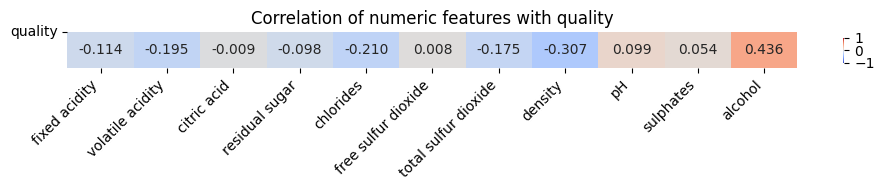

alcohol                 0.435575
density                -0.307123
chlorides              -0.209934
volatile acidity       -0.194723
total sulfur dioxide   -0.174737
fixed acidity          -0.113663
pH                      0.099427
residual sugar         -0.097577
sulphates               0.053678
citric acid            -0.009209
free sulfur dioxide     0.008158
dtype: float64


In [27]:
corr_series = correlation_with_target(white_wine, 'quality')
print(corr_series)

#### 3. Map the quality column into categorical classes as follows:

* 9-Best
* 8_Best
* 7-Good
* 6-Good
* 5- Average
* 4-Bad
* 3=Bad

In [28]:
white_wine = white_wine.replace({"quality":{9:"Best",8:"Best",7:"Good",6:"Good",5:"Average",4:"Bad",3:"Bad"}})


#### 4. Ensure this mapped categorical target is used for all subsequent modelling steps.

In [29]:
# Checking to see if the code above worked
white_wine.head(6)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,Good
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,Good
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,Good
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,Good
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,Good
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,Good


#### 5. Split the dataset into features x and target y.

In [30]:
X= white_wine.drop(columns='quality', axis=1)
y=white_wine.quality


#### 6. Apply appropriate scaling (StandardScaler or MinMaxScaler) to all numerical features


In [31]:
# Using the MinMaxScaler as our scaler
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)


## **3. Build a Base Classification Model**

##### 1. Split the data into training and testing sets (e.g 80/20).

In [32]:
# Splitthe dataset into training and test sets by 80 train and 20 tests.
X_train, X_test, y_train,y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

##### 2. Train a simple model such as Logistic Regression or Decision Tree Classifier.


In [33]:

# Train the model using Logistic Regression
model = LogisticRegression(random_state=42)
model.fit(X_train,y_train)
# Get the prediction from the model
y_pred = model.predict(X_test)

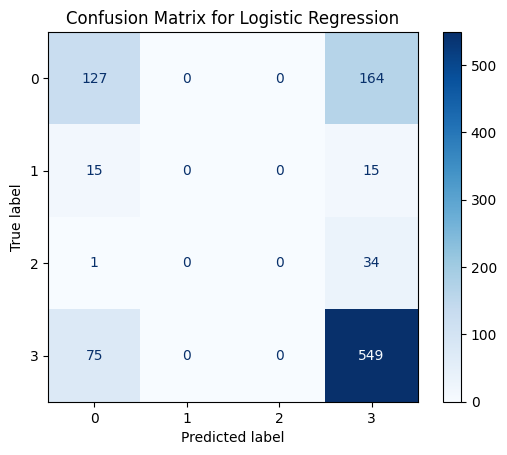

In [36]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix for Logistic Regression")
plt.show()

#### 3. Evaluate a model using Accuracy, Precision, Recall, F1-score and a Confusion Matrix

## 4. Buiild and Compare Multiple Models

In [45]:
#Libraries different ensemble classifiers
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
    
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib


In [41]:
# tain at least three classification models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": RandomForestClassifier(), 
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier()
    
}


In [42]:
# initialize a dictionary to store the models
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy}")


Training Logistic Regression...
Logistic Regression Accuracy: 0.689795918367347
Training SVM...
SVM Accuracy: 0.8010204081632653
Training Decision Tree...
Decision Tree Accuracy: 0.7204081632653061
Training K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.6918367346938775


##### 5. Optimize Model Using Rnadomized Search

In [46]:
# lets tune Random Forest - Hyperparameters
param_grid = {
    "n_estimators" : [50, 100, 200],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# # lets define GridSearchCV
# grid_search = GridSearchCV(RandomForestClassifier(random_state = 234), param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 1)
# grid_search.fit(X_train, y_train)
# print(f"Best parameters for Random Forest: {grid_search.best_params_}")

random_search=RandomizedSearchCV(RandomForestClassifier(random_state=234),param_distributions=param_grid,n_iter=10,cv=5,n_jobs=-1,verbose=1,random_state=42)
random_search.fit(X_train,y_train)
print(f"Best parameters for Random Forest: {random_search.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}


In [51]:
# Cross validation score for the best model - Random Forest
Best_model = random_search.best_estimator_
cv_scores = cross_val_score(Best_model, X_scaled, y, cv = 5)
print(f"Cross-validation scores for Random Forest: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Classification report for the best model
y_pred = Best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division = 1))

Cross-validation scores for Random Forest: [0.65612245 0.6622449  0.70306122 0.68845761 0.70786517]
Mean cross-validation score: 0.6835502699547643

Classification Report:
              precision    recall  f1-score   support

     Average       0.74      0.67      0.71       291
         Bad       0.70      0.23      0.35        30
        Best       1.00      0.43      0.60        35
        Good       0.82      0.91      0.86       624

    accuracy                           0.80       980
   macro avg       0.82      0.56      0.63       980
weighted avg       0.80      0.80      0.79       980



In [53]:
# lets save our best model as a pickle file
joblib.dump(Best_model, "model.pkl")

# lets save the scaler (MinMaxScaler used for the feature scaling)
joblib.dump(scaler, "scaler.pkl")
print("Model and scaler have been saved successfully.")

Model and scaler have been saved successfully.
